In [2]:
import pandas as pd

In [3]:
products = pd.read_csv("amazon_baby_subset.csv")
products = products.astype(str)
#pd.read_csv intelligently converts input to python datatypes.

In [4]:
products[1:10]

,name,review,rating,sentiment
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1


In [3]:
products['rating'] = products['rating'].astype(int)
products['sentiment'] = products['sentiment'].astype(int)

In [4]:
products = products.fillna({'reveiw':''}) #fill in N/A's in the review column

In [5]:
#Write a function remove_punctuation that takes a line of text and removes all punctuation from that text
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [34]:
#read "important_words.json" file
import json

with open('important_words.json') as data_file:
    important_words = json.load(data_file)
with open('module-4-assignment-train-idx.json') as data_file:
    train_index = json.load(data_file)
with open('module-4-assignment-validation-idx.json') as data_file:
    validation_index = json.load(data_file)

In [35]:
#now we proceed with the second item. For each word in important_words, 
#we compute a count for the number of times the word occurs in the review.
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

In [36]:
print products.shape

(53072, 198)


In [37]:
train_data = products.iloc[train_index]
validation_data = products.iloc[validation_index]

In [80]:
print train_data.shape
print validation_data.shape

(42361, 199)
(10711, 199)


In [38]:
import numpy as np

In [39]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    features_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(features_matrix, label_array)

In [40]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/Users/chnagikchoi/anaconda/envs/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


##Building a logistic regression
We gonna use a same functions from logistic regression without l2_penalty
and add l2_penalty on it

In [41]:
#Estimating conditional probability with link function
#produces probabilistic estimate for P(y_i = +1| x_i, w).
#estimate ranges between 0 and 1
def predict_probability(feature_matrix, coefficients):
    #Take dot product of feature_matrix and coefficients
    score = np.dot(feature_matrix, coefficients)
    #Compute P(y_i = +1|x_i, w) using the link function
    predictions = 1/(1+np.exp(-score))
    return predictions
    

In [81]:
#Compute derivative of log likelihood with respect to a single coefficient
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):
    #Compute the dot product of errors and feature(without L2 penalty)
    derivative = np.dot(errors, feature)
    
    #add L2 penalty term for any feature that isn't the intercept
    if not feature_is_constant:
        derivative = derivative - (2*l2_penalty*coefficient)
    return derivative

In [82]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment == +1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1) * scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

In [83]:
from math import sqrt
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) #make sure it's a numpy array
    for itr in xrange(max_iter):
        #Predict P(y_i = +1|x_1,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        #compute indicator value for (y_i = +1)
        indicator = (sentiment == +1)
        
        #Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        for j in xrange(len(coefficients)): #loop over each coefficient
            is_intercept = (j==0)
            #Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            #compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            #add step size times the derivative to the current coefficient(l2_penalty is already added)
            coefficients[j] = coefficients[j] + (step_size * derivative)
        
        #Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr %10 ==0) or \
            (itr <= 1000 and itr %100 ==0) or (itr <= 10000 and itr %1000 ==0) or itr % 10000 ==0:
                lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
                print 'iteration %*d : log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter ))), itr, lp)
    return coefficients


In [84]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501

In [85]:
l2_penalty = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29179.39138303
iteration   1 : log likelihood of observed labels = -29003.71259047
iteration   2 : log likelihood of observed labels = -28834.66187288
iteration   3 : log likelihood of observed labels = -28671.70781507
iteration   4 : log likelihood of observed labels = -28514.43078198
iteration   5 : log likelihood of observed labels = -28362.48344665
iteration   6 : log likelihood of observed labels = -28215.56713122
iteration   7 : log likelihood of observed labels = -28073.41743783
iteration   8 : log likelihood of observed labels = -27935.79536396
iteration   9 : log likelihood of observed labels = -27802.48168669
iteration  10 : log likelihood of observed labels = -27673.27331484
iteration  11 : log likelihood of observed labels = -27547.98083656
iteration  12 : log likelihood of observed labels = -27426.42679977
iteration  13 : log likelihood of observed labels = -27308.44444728
iteration  14 : log likelihood of observed label

In [86]:
l2_penalty = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29179.39508175
iteration   1 : log likelihood of observed labels = -29003.73417180
iteration   2 : log likelihood of observed labels = -28834.71441858
iteration   3 : log likelihood of observed labels = -28671.80345068
iteration   4 : log likelihood of observed labels = -28514.58077957
iteration   5 : log likelihood of observed labels = -28362.69830317
iteration   6 : log likelihood of observed labels = -28215.85663259
iteration   7 : log likelihood of observed labels = -28073.79071393
iteration   8 : log likelihood of observed labels = -27936.26093762
iteration   9 : log likelihood of observed labels = -27803.04751805
iteration  10 : log likelihood of observed labels = -27673.94684207
iteration  11 : log likelihood of observed labels = -27548.76901327
iteration  12 : log likelihood of observed labels = -27427.33612958
iteration  13 : log likelihood of observed labels = -27309.48101569
iteration  14 : log likelihood of observed label

In [87]:
l2_penalty = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29179.40062984
iteration   1 : log likelihood of observed labels = -29003.76654163
iteration   2 : log likelihood of observed labels = -28834.79322654
iteration   3 : log likelihood of observed labels = -28671.94687528
iteration   4 : log likelihood of observed labels = -28514.80571589
iteration   5 : log likelihood of observed labels = -28363.02048079
iteration   6 : log likelihood of observed labels = -28216.29071186
iteration   7 : log likelihood of observed labels = -28074.35036891
iteration   8 : log likelihood of observed labels = -27936.95892966
iteration   9 : log likelihood of observed labels = -27803.89576265
iteration  10 : log likelihood of observed labels = -27674.95647005
iteration  11 : log likelihood of observed labels = -27549.95042714
iteration  12 : log likelihood of observed labels = -27428.69905549
iteration  13 : log likelihood of observed labels = -27311.03455140
iteration  14 : log likelihood of observed label

In [88]:
l2_penalty = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29179.48385120
iteration   1 : log likelihood of observed labels = -29004.25177457
iteration   2 : log likelihood of observed labels = -28835.97382190
iteration   3 : log likelihood of observed labels = -28674.09410083
iteration   4 : log likelihood of observed labels = -28518.17112932
iteration   5 : log likelihood of observed labels = -28367.83774654
iteration   6 : log likelihood of observed labels = -28222.77708939
iteration   7 : log likelihood of observed labels = -28082.70799392
iteration   8 : log likelihood of observed labels = -27947.37595368
iteration   9 : log likelihood of observed labels = -27816.54738615
iteration  10 : log likelihood of observed labels = -27690.00588850
iteration  11 : log likelihood of observed labels = -27567.54970126
iteration  12 : log likelihood of observed labels = -27448.98991327
iteration  13 : log likelihood of observed labels = -27334.14912742
iteration  14 : log likelihood of observed label

In [89]:
l2_penalty = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29180.31606471
iteration   1 : log likelihood of observed labels = -29009.07176112
iteration   2 : log likelihood of observed labels = -28847.62378912
iteration   3 : log likelihood of observed labels = -28695.14439397
iteration   4 : log likelihood of observed labels = -28550.95060743
iteration   5 : log likelihood of observed labels = -28414.45771129
iteration   6 : log likelihood of observed labels = -28285.15124375
iteration   7 : log likelihood of observed labels = -28162.56976044
iteration   8 : log likelihood of observed labels = -28046.29387744
iteration   9 : log likelihood of observed labels = -27935.93902900
iteration  10 : log likelihood of observed labels = -27831.15045502
iteration  11 : log likelihood of observed labels = -27731.59955260
iteration  12 : log likelihood of observed labels = -27636.98108219
iteration  13 : log likelihood of observed labels = -27547.01092670
iteration  14 : log likelihood of observed label

In [90]:
l2_penalty = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter)

iteration   0 : log likelihood of observed labels = -29271.85955115
iteration   1 : log likelihood of observed labels = -29271.71006589
iteration   2 : log likelihood of observed labels = -29271.65738833
iteration   3 : log likelihood of observed labels = -29271.61189923
iteration   4 : log likelihood of observed labels = -29271.57079975
iteration   5 : log likelihood of observed labels = -29271.53358505
iteration   6 : log likelihood of observed labels = -29271.49988440
iteration   7 : log likelihood of observed labels = -29271.46936584
iteration   8 : log likelihood of observed labels = -29271.44172890
iteration   9 : log likelihood of observed labels = -29271.41670149
iteration  10 : log likelihood of observed labels = -29271.39403722
iteration  11 : log likelihood of observed labels = -29271.37351294
iteration  12 : log likelihood of observed labels = -29271.35492661
iteration  13 : log likelihood of observed labels = -29271.33809523
iteration  14 : log likelihood of observed label

#How to build table in python

In [ ]:
#from astropy.table import Table, Columnfrom astropy.table import Table, Column
#table= Table()
#table['word'] = important_words
#table['l2_penalty_0'] = coefficients_0_penalty[1:]
#table['l2_penalty_4'] = coefficients_4_penalty[1:]
#table['l2_penalty_10'] = coefficients_10_penalty[1:]
#table['l2_penalty_1e2'] = coefficients_1e2_penalty[1:]
#table['l2_penalty_1e5'] = coefficients_1e5_penalty[1:]
#print table

In [91]:
#but we gonna use this DataFrame
import pandas as pd
table = pd.DataFrame({'word': important_words, 'l2_penalty_0': coefficients_0_penalty[1:],
                  'l2_penalty_4': coefficients_4_penalty[1:], 'l2_penalty_10': coefficients_10_penalty[1:],
                  'l2_penalty_1e2': coefficients_1e2_penalty[1:], 'l2_penalty_1e5': coefficients_1e5_penalty[1:]})
print table[1:10]
print table.shape

   l2_penalty_0  l2_penalty_10  l2_penalty_1e2  l2_penalty_1e5  l2_penalty_4  \
1      0.012753       0.012115        0.007247       -0.001827      0.012495   
2      0.801625       0.789935        0.701425        0.008950      0.796897   
3      1.058554       1.039529        0.896644        0.009042      1.050856   
4     -0.000104       0.000556        0.005481        0.000418      0.000163   
5     -0.287021      -0.284564       -0.265993       -0.008127     -0.286027   
6     -0.003384      -0.003527       -0.004635       -0.000827     -0.003442   
7      0.984559       0.967362        0.838245        0.008808      0.977600   
8      0.524419       0.516917        0.460235        0.005941      0.521385   
9     -0.086968      -0.084883       -0.069109        0.000611     -0.086125   

     word  
1     one  
2   great  
3    love  
4     use  
5   would  
6    like  
7    easy  
8  little  
9    seat  
(193, 6)


In [92]:
table = table.sort(['l2_penalty_0'], ascending=[0])
positive_words = table[1:6]['word']
negative_words = table[-6:-1]['word']
print positive_words
print negative_words

22      loves
7        easy
33    perfect
2       great
82      happy
Name: word, dtype: object
171       broke
168    returned
112       waste
113      return
96        money
Name: word, dtype: object


KeyError: 0

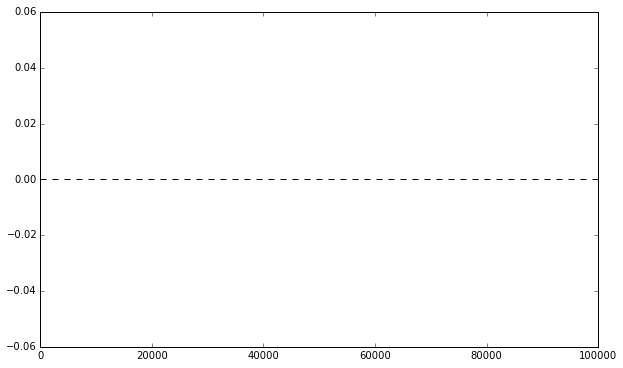

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [2]:
 table_positive_words = table[table['word'].isin(positive_words)]
table_positive_words[1:2].as_matrix().flatten()

NameError: name 'table_positive_words' is not defined

In [94]:
def get_accuracy(feature_matrix, coefficients, sentiment):
    #compute scores using feature_matrix, coefficients
    scores = np.dot(feature_matrix, coefficients)
    #threshold scores by 0
    positive = scores > 0
    negative = scores <= 0
    scores[positive] = 1
    scores[negative] = -1

    correct = float((scores == sentiment).sum())
    total = float(len(sentiment))
    accuracy = float(correct / total)
    return accuracy

In [95]:
accuracy_0_penalty = get_accuracy(feature_matrix_train, coefficients_0_penalty, sentiment_train)
accuracy_4_penalty = get_accuracy(feature_matrix_train, coefficients_4_penalty, sentiment_train)
accuracy_10_penalty = get_accuracy(feature_matrix_train, coefficients_10_penalty, sentiment_train)
accuracy_1e2_penalty = get_accuracy(feature_matrix_train, coefficients_1e2_penalty, sentiment_train)
accuracy_1e3_penalty = get_accuracy(feature_matrix_train, coefficients_1e3_penalty, sentiment_train)
accuracy_1e5_penalty = get_accuracy(feature_matrix_train, coefficients_1e5_penalty, sentiment_train)

In [96]:
print accuracy_0_penalty
print accuracy_4_penalty
print accuracy_10_penalty
print accuracy_1e2_penalty
print accuracy_1e3_penalty
print accuracy_1e5_penalty

0.785156157787
0.785108944548
0.784990911452
0.783975826822
0.775855149784
0.680366374731


In [97]:
accuracy_0_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_0_penalty, sentiment_valid)
accuracy_4_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_4_penalty, sentiment_valid)
accuracy_10_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_10_penalty, sentiment_valid)
accuracy_1e2_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_1e2_penalty, sentiment_valid)
accuracy_1e3_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_1e3_penalty, sentiment_valid)
accuracy_1e5_penalty_valid = get_accuracy(feature_matrix_valid, coefficients_1e5_penalty, sentiment_valid)

In [79]:
print accuracy_0_penalty_valid
print accuracy_4_penalty_valid
print accuracy_10_penalty_valid
print accuracy_1e2_penalty_valid
print accuracy_1e3_penalty_valid
print accuracy_1e5_penalty_valid

0.78143964149
0.781252917561
0.781533003454
0.782653347026
0.780225935954
0.74848286808
